# Introduction

The aim of this project is to ...

## Dataset

The dataset used is retrieved from: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

## Importing Packages

Let us begin by importing the relevant packages.

In [83]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import torch 
from torch.utils.data import ConcatDataset, Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# 1. Reading the images

In [84]:
# Define the path pattern to read images containing brain tumours
path1 = './data/brain_tumor_dataset/yes/*'

# List to store images
tumor = []

# Get all files in the directory
for file in glob.iglob(path1):
    if file.lower().endswith(('.jpg', '.jpeg')):  # Check for both lower and upper case
        img = cv2.imread(file)
        img = cv2.resize(img, (128,128)) # Resizing images
        b, g, r = cv2.split(img) 
        img = cv2.merge([r,g,b])
        tumor.append(img)

In [85]:
# Define the path pattern to read images that do not contain brain tumours
path2 = './data/brain_tumor_dataset/no/*'

# List to store images
healthy = []

# Get all files in the directory
for file in glob.iglob(path2):
    if file.lower().endswith(('.jpg', '.jpeg')):  # Check for both lower and upper case
        img = cv2.imread(file)
        img = cv2.resize(img, (128,128)) # Resizing images
        b, g, r = cv2.split(img) 
        img = cv2.merge([r,g,b])
        healthy.append(img)

In [103]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [104]:
healthy.shape

(97, 128, 128, 3)

In [105]:
tumor.shape

(154, 128, 128, 3)

## 2. Visualising Brain MRI Images

In [87]:
def plot_random_img(healthy, tumor, num = 5):
    healthy_imgs = healthy[np.random.choice(len(healthy), num, replace = False)]
    tumor_imgs = tumor[np.random.choice(len(tumor), num, replace = False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num, i+1)
        plt.title(f"Healthy Brain {i + 1}")
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num, i+1)
        plt.title(f"Brain with Tumor {i + 1}")
        plt.imshow(tumor_imgs[i])
        

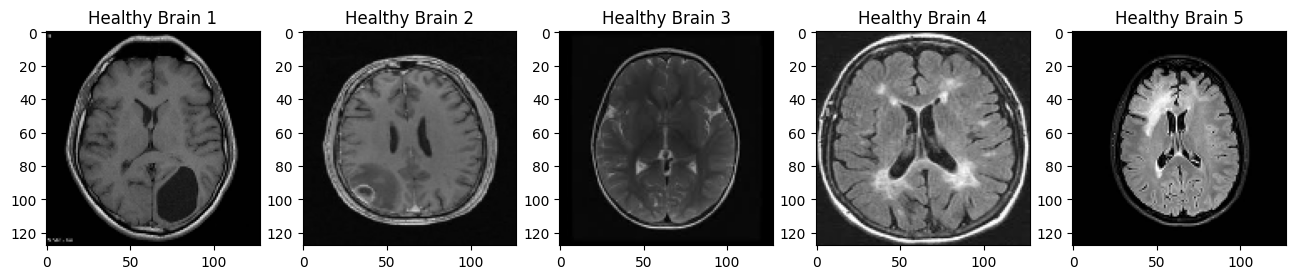

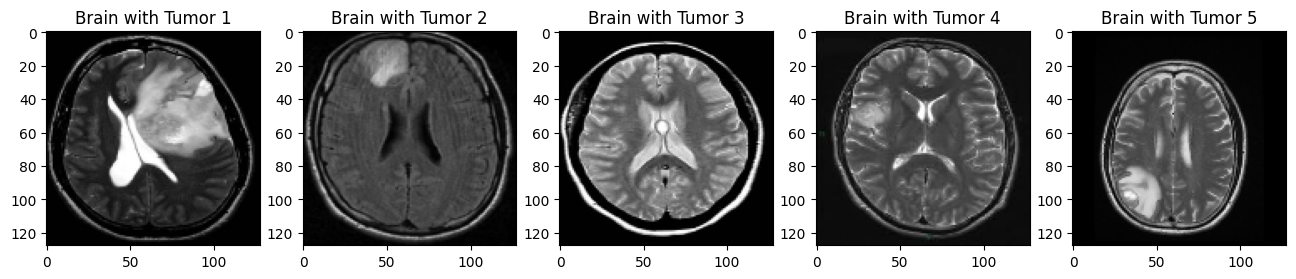

In [88]:
plot_random_img(healthy, tumor, num = 5)

# 3. Creating a customised Dataset Class

## PyTorch's Abstract Dataset class:

In [89]:
class Dataset(object):
    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self,other])


In [113]:
class MRI(Dataset):
    def __init__(self):
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/brain_tumor_dataset/yes/*"):
            if file.lower().endswith(('.jpg', '.jpeg')):
                img = cv2.imread(f)
                img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
                b, g, r = cv2.split(img)
                img = cv2.merge([r,g,b])
                img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
                tumor.append(img)

        for f in glob.iglob("./data/brain_tumor_dataset/no/*"):
            if file.lower().endswith(('.jpg', '.jpeg')):
                img = cv2.imread(f)
                img = cv2.resize(img,(128,128)) 
                b, g, r = cv2.split(img)
                img = cv2.merge([r,g,b])
                img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
                healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 'label':self.labels[index]}
        
        return sample
    
    def normalise(self):
        self.images = self.images/255.0


In [114]:
mri_dataset = MRI()
mri_dataset.normalise()
print(len(mri_dataset))

253


# 5. Creating a CNN Model

## Explain the rationale behind the numbers..

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), 
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5)
        )

        self.fc_model = nn.Sequential(
            nn.Linear(in_features=256, out_features = 120),
            nn.Tanh(),
            nn.Linear(in_features = 120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=1)
        )

    def forward(self,x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)

        return x
        

# 6. Evaluate a New-born Neural Network

In [94]:
print(torch.cuda.is_available())  # Should return True if a GPU is available

False


In [115]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)

In [116]:
dataloader2 = DataLoader(mri_dataset, batch_size = 32, shuffle = False)

In [117]:
model.eval()
outputs = []
y_true = []

with torch.no_grad():
    
    for item in dataloader2:
        image = item['image'].to(device)
        label = item['label'].to(device)
    
        y_hat = model(image)
    
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

In [118]:
outputs = np.concatenate(outputs, axis = 0).squeeze()
y_true = np.concatenate(y_true, axis = 0).squeeze()

In [119]:
def threshold(scores, threshold = 0.50, minimum = 0.0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x<threshold] = minimum
    return x

In [120]:
accuracy_score(y_true, threshold(outputs))

0.6126482213438735

## Plotting a Confusion Matrix

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

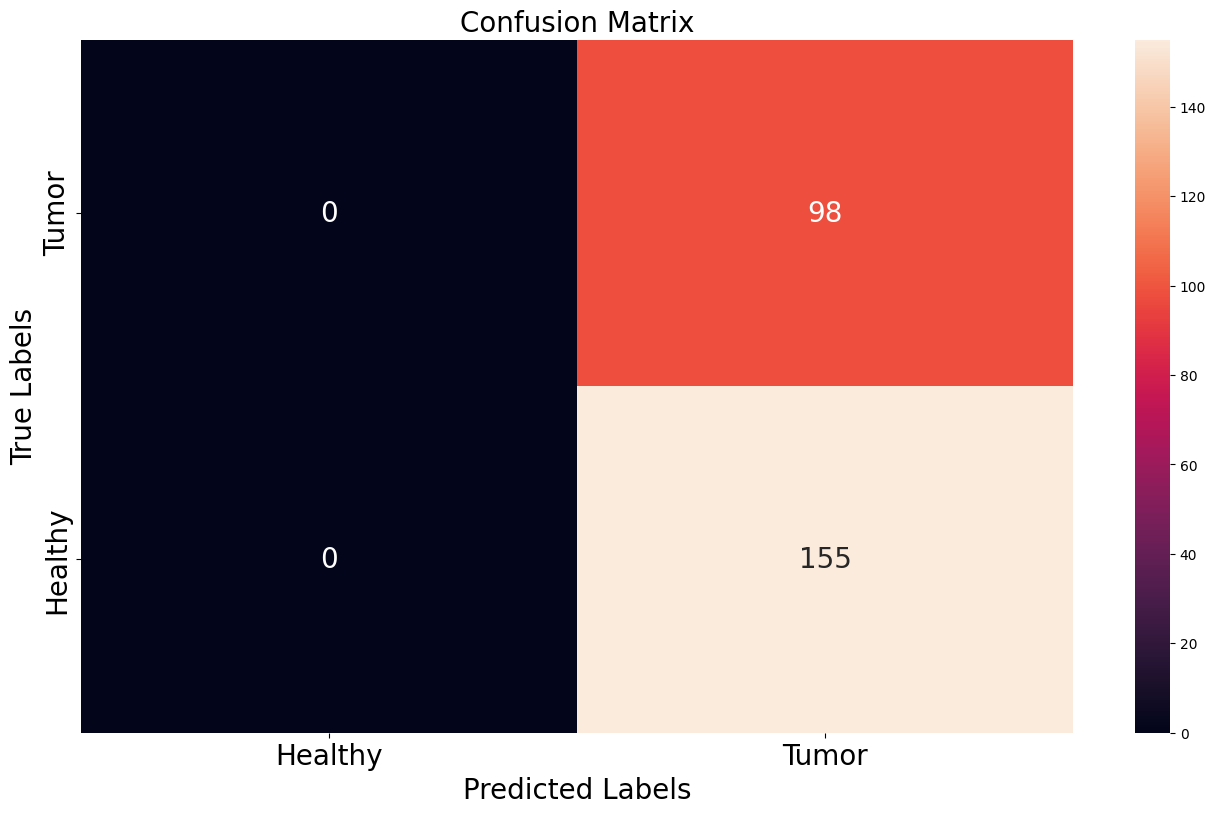

In [121]:
plt.figure(figsize = (16,9))
cm = confusion_matrix(y_true, threshold(outputs))
fig = plt.subplot()
sns.heatmap(cm, annot = True, fmt = 'g', ax = fig, annot_kws={'size':20})

fig.set_xlabel('Predicted Labels', fontsize = 20)
fig.set_ylabel('True Labels', fontsize = 20)
fig.set_title('Confusion Matrix', fontsize = 20)
fig.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize = 20)
fig.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize = 20)


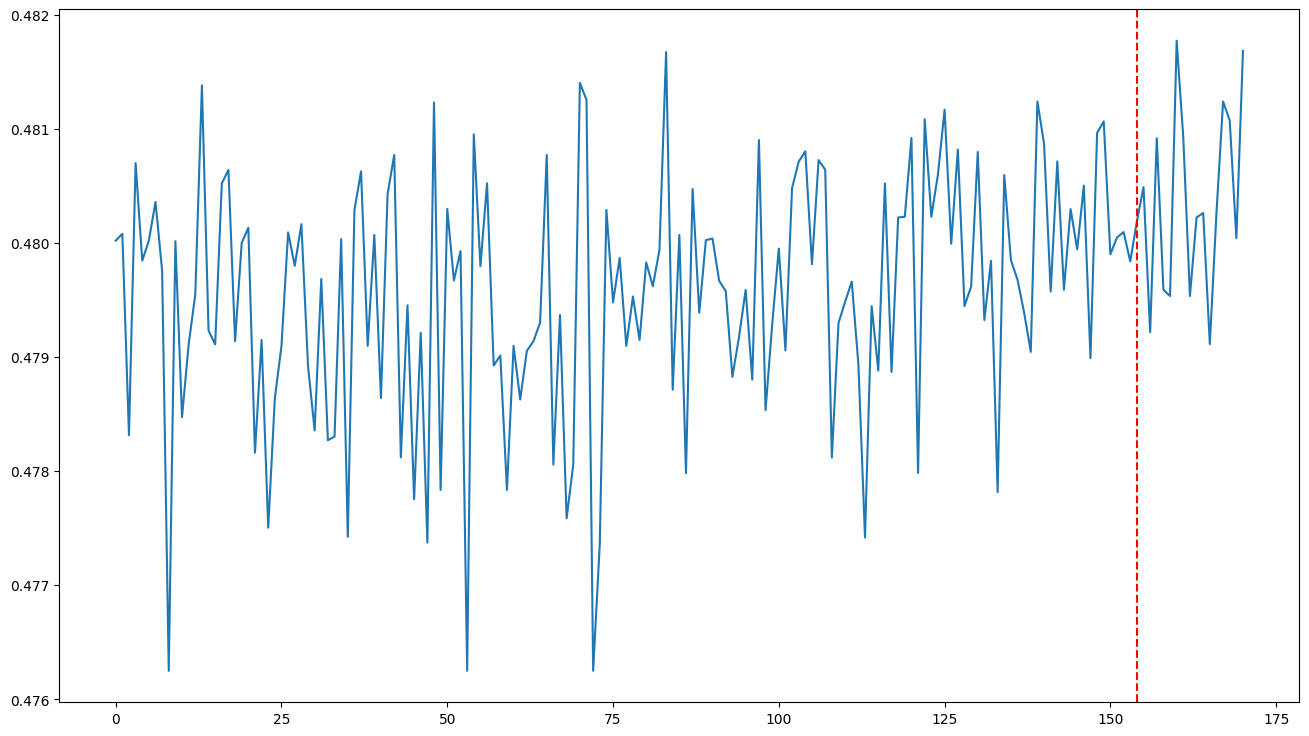

In [102]:
plt.figure(figsize = (16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color = 'r', linestyle = '--')

# 7. Training a better model

In [ ]:
eta = 0.0001
num_epoch = 400
optimiser = torch.optim.Adam(model.parameters(), lr = eta)
dataloader = DataLoader(mri_dataset, batch_size = 32, shuffle = True)
model.train()

In [ ]:
for epoch in range(1, num_epoch):
    losses = []
    for item in dataloader:
        optimiser.zero_grad()
        
        image = item['image'].to(device)
        label = item['label'].to(device)
        
        # Forward pass
        y_hat = model(image)

        # Ensure the predictions and labels have the same shape
        y_hat = y_hat.view(-1)  # Flatten predictions to [batch_size]
        label = label.view(-1)  # Flatten labels to [batch_size]

        # Calculate the Binary Cross-Entropy Loss
        err = nn.BCELoss()
        loss = err(y_hat, label)

        # Backward pass
        loss.backward()
        optimiser.step()

        losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch + 1, np.mean(losses)))
    

accuracy score: 0.6126482213438735


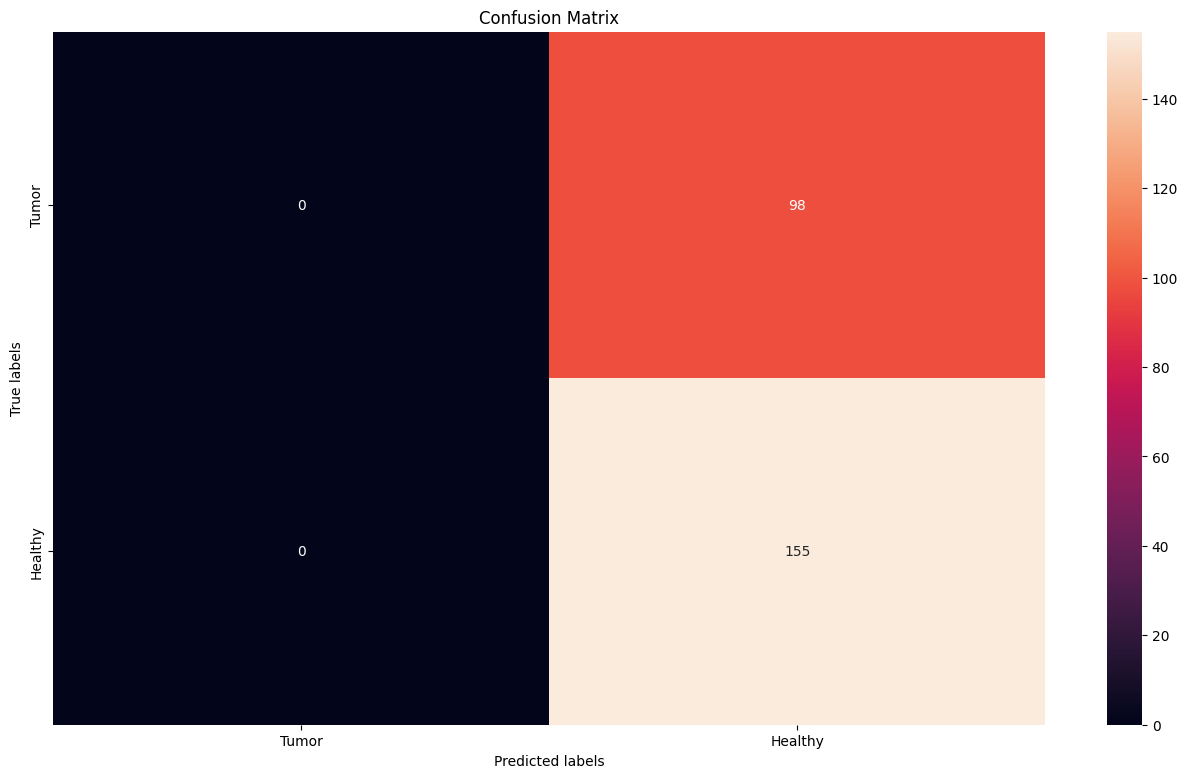

In [128]:
# plot confusion matrix and line graph again
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

print(f"accuracy score: {accuracy_score(y_true, threshold(outputs))}")

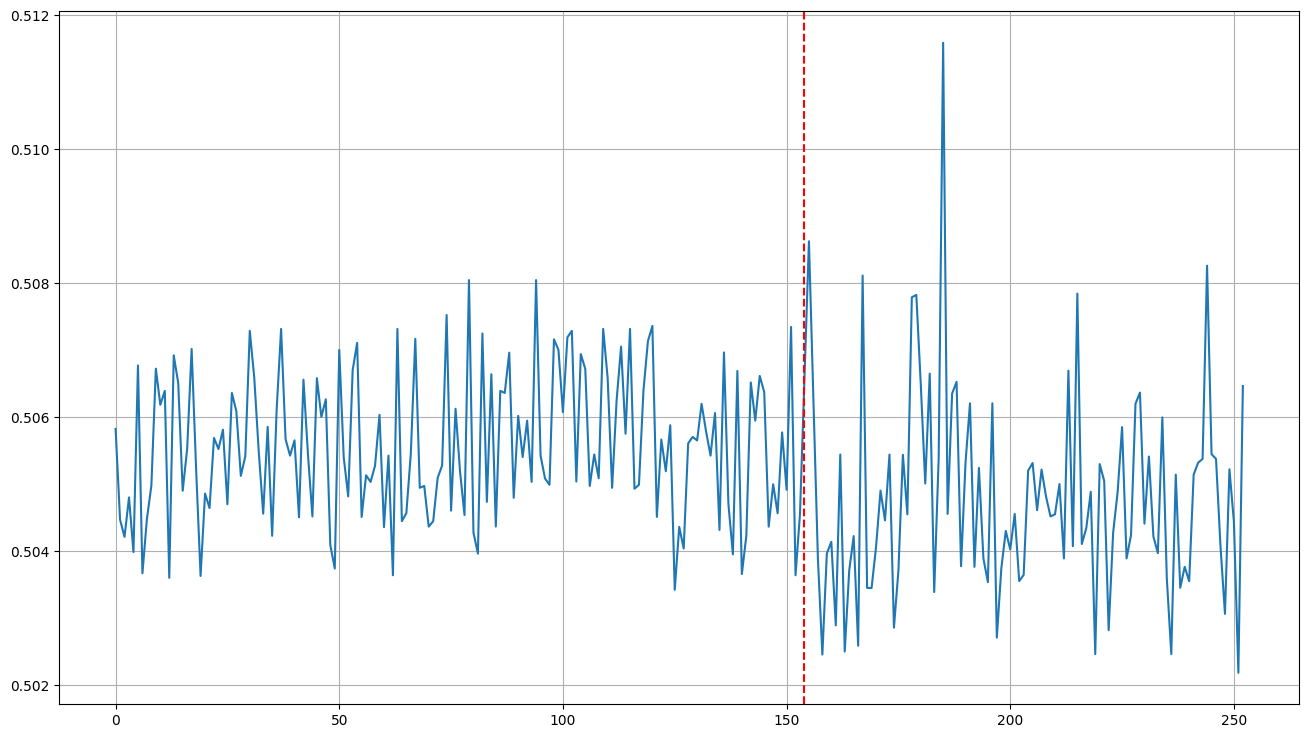

In [125]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

# 8. Visualising the Feature Maps of the Convolutional Filters

In [129]:
num_layers = 0
conv_layers = []

In [130]:
model_children = list(model.children())

In [131]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                num_layers += 1
                conv_layers.append(layer)

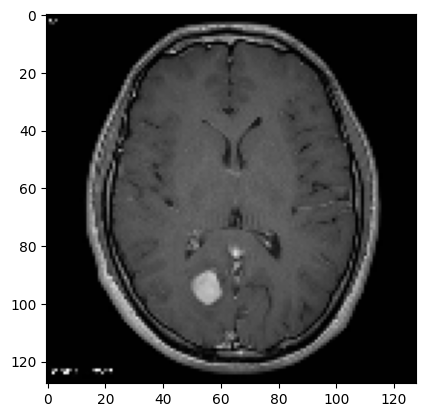

In [132]:
img = mri_dataset[1]['image']
plt.imshow(img.reshape(128,128,3))

In [133]:
img = torch.from_numpy(img).to(device)

In [134]:
img.shape

torch.Size([3, 128, 128])

In [135]:
img = img.unsqueeze(0)

In [136]:
results = [conv_layers[0](img)]
for i in range(1,len(conv_layers)):
    results.append(conv_layers[i](results[-1]))

outputs = results

In [137]:
len(outputs)

2

Layer  1


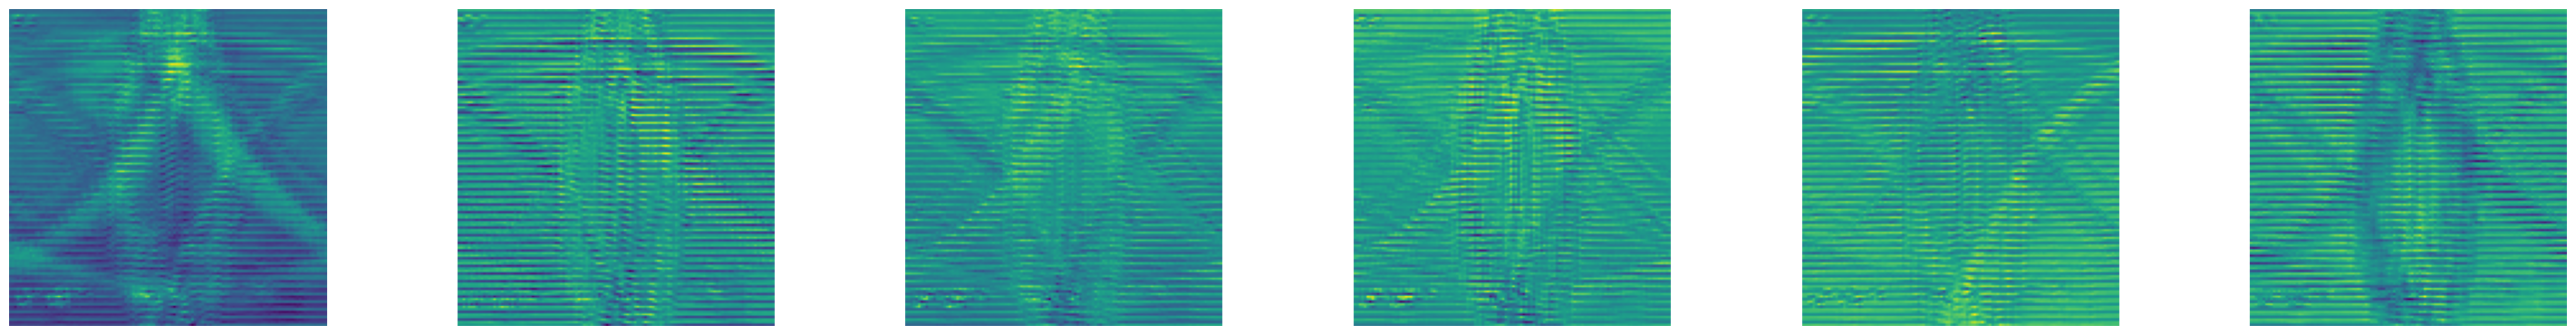

Layer  2


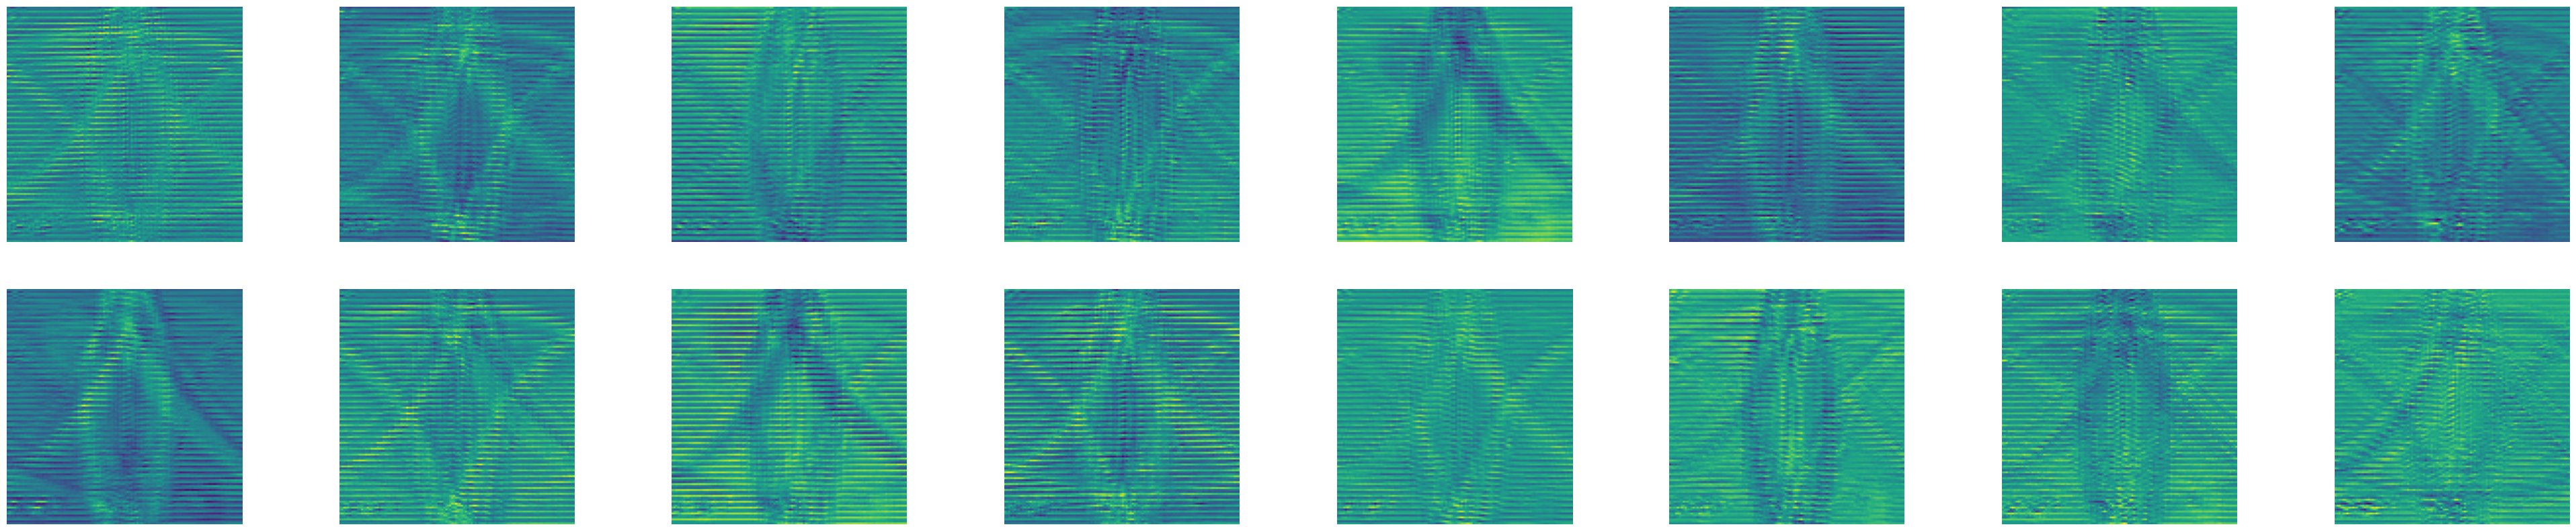

In [138]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50,10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2,8, i+1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

# Are we overfitting?

In [139]:

class MRI(Dataset):
    
    def __init__(self):
        
        # Variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        
        # A variable to determine if we are interested in retrieving the training OR the validation data
        self.mode = 'train'
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
    
    # Define a function that would separate the data into Training and Validation sets
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)
        
    def __len__(self):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
    
    def __getitem__(self, idx):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}
        
        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}
        
        return sample
    
    def normalise(self):
        self.images = self.images/255.0

In [140]:
mri_dataset2 = MRI()
mri_dataset2.normalise()
mri_dataset2.train_val_split()

In [141]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [142]:
device = torch.device("cpu")
model = CNN().to(device)

In [143]:
eta=0.0001
optimiser = torch.optim.Adam(model.parameters(), lr=eta)

In [144]:
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(1,600):
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimiser.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimiser.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    # validate for the current epoch
    val_losses = []
    model.eval()
    
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:            
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))

Train Epoch: 10	Train Loss: 0.625685	Val Loss: 0.626745
Train Epoch: 20	Train Loss: 0.555172	Val Loss: 0.553214
Train Epoch: 30	Train Loss: 0.539767	Val Loss: 0.540293
Train Epoch: 40	Train Loss: 0.532593	Val Loss: 0.534331
Train Epoch: 50	Train Loss: 0.528858	Val Loss: 0.528338
Train Epoch: 60	Train Loss: 0.517833	Val Loss: 0.520270
Train Epoch: 70	Train Loss: 0.510086	Val Loss: 0.511742
Train Epoch: 80	Train Loss: 0.496911	Val Loss: 0.498482
Train Epoch: 90	Train Loss: 0.485732	Val Loss: 0.485280
Train Epoch: 100	Train Loss: 0.464173	Val Loss: 0.465505
Train Epoch: 110	Train Loss: 0.444604	Val Loss: 0.443830
Train Epoch: 120	Train Loss: 0.420777	Val Loss: 0.420327
Train Epoch: 130	Train Loss: 0.398724	Val Loss: 0.397583
Train Epoch: 140	Train Loss: 0.378035	Val Loss: 0.374882
Train Epoch: 150	Train Loss: 0.362998	Val Loss: 0.352235
Train Epoch: 160	Train Loss: 0.333847	Val Loss: 0.331337
Train Epoch: 170	Train Loss: 0.309836	Val Loss: 0.306189
Train Epoch: 180	Train Loss: 0.298414	Va

Text(0, 0.5, 'Loss')

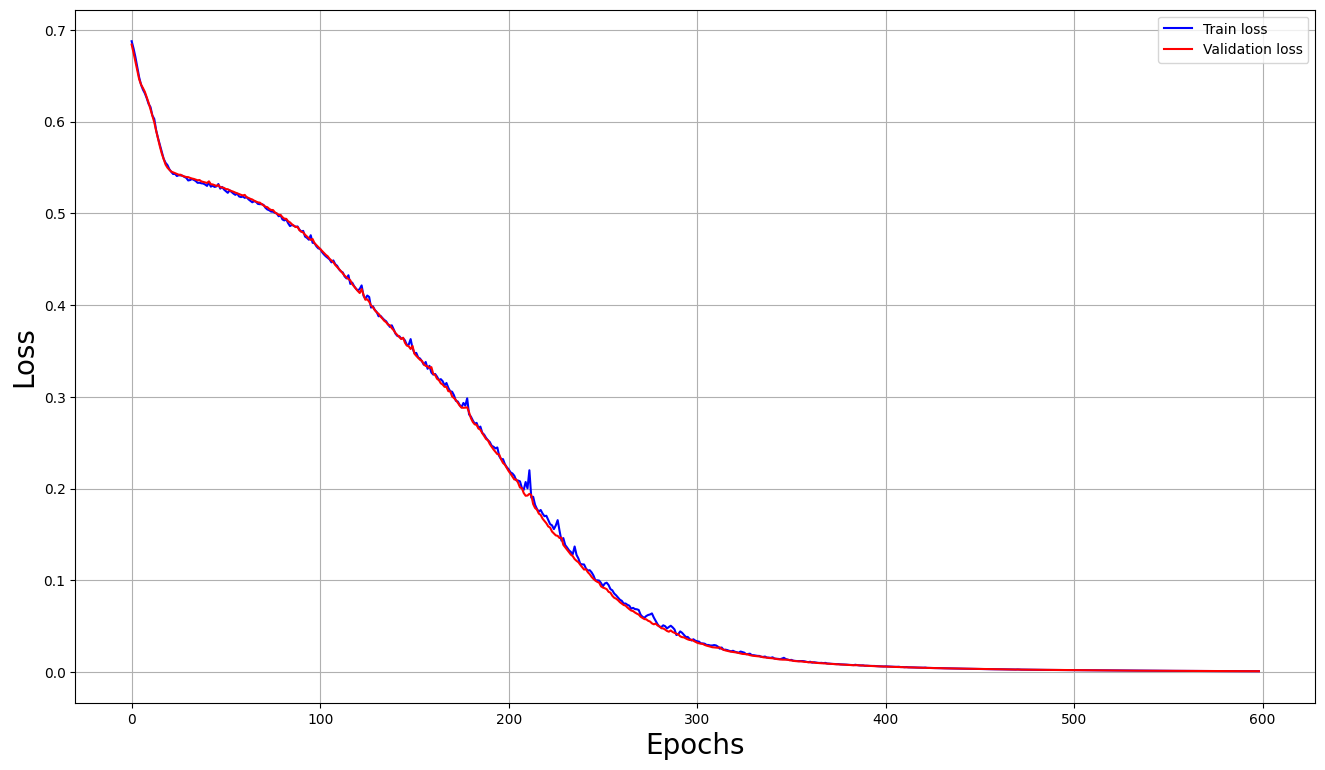

In [145]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)

In [146]:
from sklearn.metrics import accuracy_score

for epoch in range(1, 600):
    train_losses = []
    train_true_labels = []
    train_pred_labels = []
    
    # Train the model for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    
    for D in train_dataloader:
        # Reset gradients
        optimiser.zero_grad()
        
        data = D['image'].to(device)
        label = D['label'].to(device)
        
        # Forward pass
        y_hat = model(data)
        
        # Calculate loss
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        
        # Backward pass
        loss.backward()
        optimiser.step()
        
        # Store loss
        train_losses.append(loss.item())
        
        # Store true and predicted labels for accuracy calculation
        train_true_labels.extend(label.cpu().numpy())
        train_pred_labels.extend((y_hat.squeeze().detach().cpu().numpy() > 0.5).astype(int))  # Detach before converting to NumPy

    # Calculate training accuracy
    train_accuracy = accuracy_score(train_true_labels, train_pred_labels)
    epoch_train_loss.append(np.mean(train_losses))
    
    # Validation for the current epoch
    val_losses = []
    val_true_labels = []
    val_pred_labels = []
    model.eval()
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            
            # Calculate loss
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())
            
            # Store true and predicted labels for accuracy calculation
            val_true_labels.extend(label.cpu().numpy())
            val_pred_labels.extend((y_hat.squeeze().detach().cpu().numpy() > 0.5).astype(int))  # Detach before converting to NumPy

    # Calculate validation accuracy
    val_accuracy = accuracy_score(val_true_labels, val_pred_labels)
    epoch_val_loss.append(np.mean(val_losses))
    
    if (epoch + 1) % 10 == 0:
        print(f"Train Epoch: {epoch+1}\tTrain Loss: {np.mean(train_losses):.6f}\tVal Loss: {np.mean(val_losses):.6f}")
        print(f"Train Accuracy: {train_accuracy:.4f}\tVal Accuracy: {val_accuracy:.4f}")


Train Epoch: 10	Train Loss: 0.000869	Val Loss: 0.000859
Train Accuracy: 1.0000	Val Accuracy: 1.0000
Train Epoch: 20	Train Loss: 0.000804	Val Loss: 0.000803
Train Accuracy: 1.0000	Val Accuracy: 1.0000
Train Epoch: 30	Train Loss: 0.000753	Val Loss: 0.000748
Train Accuracy: 1.0000	Val Accuracy: 1.0000
Train Epoch: 40	Train Loss: 0.000705	Val Loss: 0.000696
Train Accuracy: 1.0000	Val Accuracy: 1.0000
Train Epoch: 50	Train Loss: 0.000658	Val Loss: 0.000651
Train Accuracy: 1.0000	Val Accuracy: 1.0000
Train Epoch: 60	Train Loss: 0.000612	Val Loss: 0.000607
Train Accuracy: 1.0000	Val Accuracy: 1.0000
Train Epoch: 70	Train Loss: 0.000575	Val Loss: 0.000570
Train Accuracy: 1.0000	Val Accuracy: 1.0000
Train Epoch: 80	Train Loss: 0.000538	Val Loss: 0.000533
Train Accuracy: 1.0000	Val Accuracy: 1.0000
Train Epoch: 90	Train Loss: 0.000507	Val Loss: 0.000500
Train Accuracy: 1.0000	Val Accuracy: 1.0000
Train Epoch: 100	Train Loss: 0.000473	Val Loss: 0.000468
Train Accuracy: 1.0000	Val Accuracy: 1.0000